In [1]:
import numpy as np
import scipy
from scipy.fft import fft, fftshift
from scipy import signal
from scipy.signal import correlate
import glob
import os
import zipfile
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.pylab import ifft, fftfreq
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
from matplotlib.ticker import FuncFormatter


In [2]:
# defines the frequency axis
sampling_rate = 2.2  # sample rate in MHz
num_samples = 2048  # number of samples
freqs = np.fft.fftshift(np.fft.fftfreq(num_samples, 1 / sampling_rate))
freqs = freqs + 145.2 # frequency (+ adjustment to account for center frequency)

# other parameters
offset = 0
time_num = 12 * num_samples
t = np.arange(time_num) * 1/2.2e6
phazor = np.exp(2*np.pi*1j * 0.2e6 * t)
time = t * 1e3

In [3]:
'''Functions'''

# computes power spectra for plotting
def perform_power(signal):
    return np.abs(signal)**2

# fft shifts the signal data
def shift(signal):
    return fftshift(signal)

# creates the function to format the y-axis in terms of multiples of pi
def radian_formatter(x, pos):
    return f'{x/np.pi:.1f}π' if x != 0 else '0'

def check_and_load_files(directory):
    valid_files = []
    bad_files = []
    
    # lists all .npz files in the directory
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npz')]
    for file in files:
        try:
            # attempts to load the file to check if it's corrupted
            with np.load(file) as data:
                valid_files.append(file)
                #print(data.shape)
        except zipfile.BadZipFile:
            print(f'Bad file: {file}')
            bad_files.append(file)
        except Exception as e:
            print(f'Error in file {file}: {e}')
            bad_files.append(file)
    
    # removes bad files
    for bad_file in bad_files:
        try:
            print()
        except OSError as e:
            print(f'Error removing file {bad_file}: {e}')
    
    return valid_files

def concatenate_valid_files(valid_files):
    all_data = []
    for file in valid_files:
        try:
            # loads and append data from each valid file
            data = np.load(file)['data']
            all_data.append(data)
        except Exception as e:
            print(f'Failed to load data from {file}: {e}')
    
    # concatenates all successfully loaded data
    if all_data:
        return np.concatenate(all_data, axis=0).view('int8')
    else:
        return None


In [4]:
# Initialize three separate lists
ip_data1, ip_data2, ip_data3, ip_data4 = [], [], [], []

# List of IP addresses
ip_addresses = ["10.10.10.20", "10.10.10.30", "10.10.10.40", "10.10.10.50"]

# List of lists to map each IP address to its corresponding list
ip_data_lists = [ip_data1, ip_data2, ip_data3, ip_data4]

for idx, ip in enumerate(ip_addresses):
    # Directory containing the .npz files for the current IP address
    directory = f'output2_{ip}'
    
    # Get valid files from the directory
    valid_files = check_and_load_files(directory)
    
    # Append the list of valid files to the corresponding list
    ip_data_lists[idx].extend(valid_files)

# Print the results to verify
#print("ip_data_1:", ip_data_1)
#print("ip_data_2:", ip_data_2)
#print("ip_data_3:", ip_data_3)
print(ip_data_lists[0])
print(ip_data_lists[1])
print(ip_data_lists[2])
print(ip_data_lists[3])

# concatenates valid files
if ip_data1:
    data1 = concatenate_valid_files(np.array(ip_data1))
    data2 = concatenate_valid_files(np.array(ip_data2))
    data3 = concatenate_valid_files(np.array(ip_data3))
    data4 = concatenate_valid_files(np.array(ip_data4))
    if data1 is not None:
        #data_shape = data.shape
        print()
        #print(f'Number of files:  {num_files}')
        print(f'Data shape [{ip_addresses[0]}]:       {data1.shape}')
        print(f'Data shape [{ip_addresses[1]}]:       {data2.shape}')
        print(f'Data shape [{ip_addresses[2]}]:       {data3.shape}')
        print(f'Data shape [{ip_addresses[3]}]:       {data4.shape}')
        print()
else:
    print()
    print('Missing valid files.')
    print()


['output2_10.10.10.20/data_00086.npz', 'output2_10.10.10.20/data_00003.npz', 'output2_10.10.10.20/data_00075.npz', 'output2_10.10.10.20/data_00087.npz', 'output2_10.10.10.20/data_00100.npz', 'output2_10.10.10.20/data_00085.npz', 'output2_10.10.10.20/data_00006.npz', 'output2_10.10.10.20/data_00073.npz', 'output2_10.10.10.20/data_00015.npz', 'output2_10.10.10.20/data_00096.npz', 'output2_10.10.10.20/data_00010.npz', 'output2_10.10.10.20/data_00105.npz', 'output2_10.10.10.20/data_00013.npz', 'output2_10.10.10.20/data_00024.npz', 'output2_10.10.10.20/data_00008.npz', 'output2_10.10.10.20/data_00068.npz', 'output2_10.10.10.20/data_00004.npz', 'output2_10.10.10.20/data_00044.npz', 'output2_10.10.10.20/data_00002.npz', 'output2_10.10.10.20/data_00074.npz', 'output2_10.10.10.20/data_00099.npz', 'output2_10.10.10.20/data_00098.npz', 'output2_10.10.10.20/data_00022.npz', 'output2_10.10.10.20/data_00027.npz', 'output2_10.10.10.20/data_00048.npz', 'output2_10.10.10.20/data_00064.npz', 'output2_10

In [5]:
# converts to complex data
data_comp1 = data1[...,0] + 1j * data1[...,1]
data_comp2 = data2[...,0] + 1j * data2[...,1]
data_comp3 = data3[...,0] + 1j * data3[...,1]
data_comp4 = data4[...,0] + 1j * data4[...,1]

# creates a list of datasets and labels for IP addresses
data_comps = [data_comp1, data_comp4, data_comp2, data_comp3]
labels = ip_addresses

In [6]:
# d1 = data_comp1[0]
# d2 = data_comp2[0]

# _d1 = np.fft.fft(d1)
# _d2 = np.fft.fft(d2)

# auto1 = np.abs(_d1**2)
# auto2 = np.abs(_d2**2)

# _d12 = _d1 * _d2
# cross = np.abs(_d12**2) / np.sqrt(auto1 * auto2)

In [7]:
# plt.style.use('bmh')
# plt.figure()
# plt.plot(freqs, np.fft.fftshift(auto1))
# #plt.plot(freqs, np.fft.fftshift(auto2))
# #plt.plot(freqs, np.fft.fftshift(cross))
# plt.yscale("log")
# plt.show()


In [8]:
# dlys = np.fft.fftfreq(_d12.size, freqs[1]-freqs[0])

# plt.figure()
# plt.plot(np.fft.fftshift(dlys), np.fft.fftshift(np.abs(np.fft.fft(_d12))))
# plt.show()

In [9]:
# plt.figure()
# plt.plot(freqs, np.angle(_d12))
# plt.show()

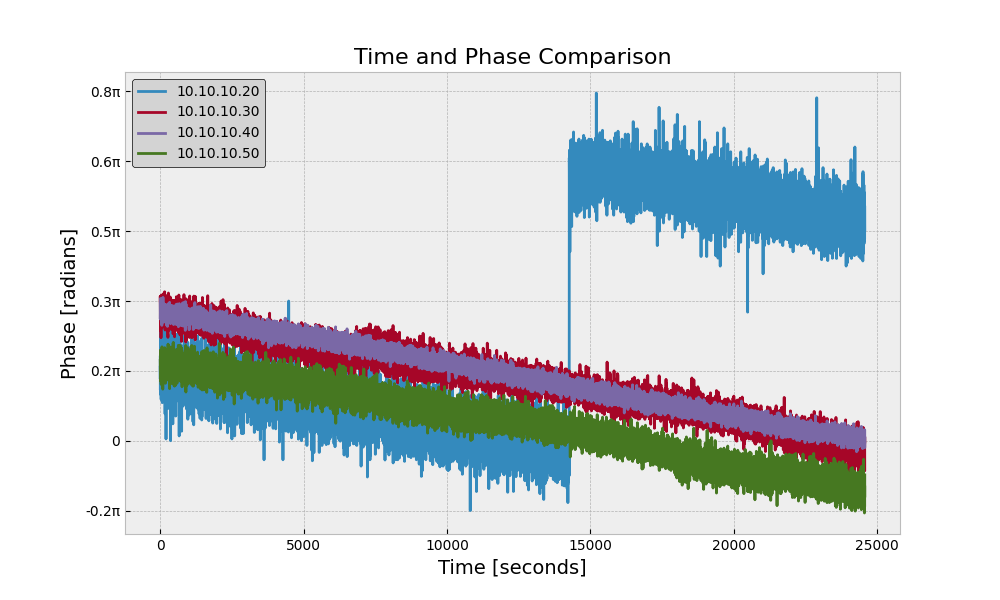

In [10]:
# Plot 1
plt.style.use('bmh')
plt.figure(figsize=(10,6))
plt.title('Time and Phase Comparison', fontsize=16)

# plots each dataset with the corresponding IP label
for data_comp, label in zip(data_comps, labels):
    plt.plot(np.unwrap(np.angle(data_comp.ravel()[offset:offset+time_num] * phazor)) / np.pi, label=label)

plt.xlabel('Time [seconds]', fontsize=14)
plt.ylabel('Phase [radians]', fontsize=14)
#plt.ylim(-np.pi, np.pi)

# formats the y-axis ticks as multiples of π
plt.gca().yaxis.set_major_formatter(FuncFormatter(radian_formatter))

plt.legend(loc='best', framealpha=1, frameon=True, facecolor='lightgray', edgecolor='k')

plt.show()


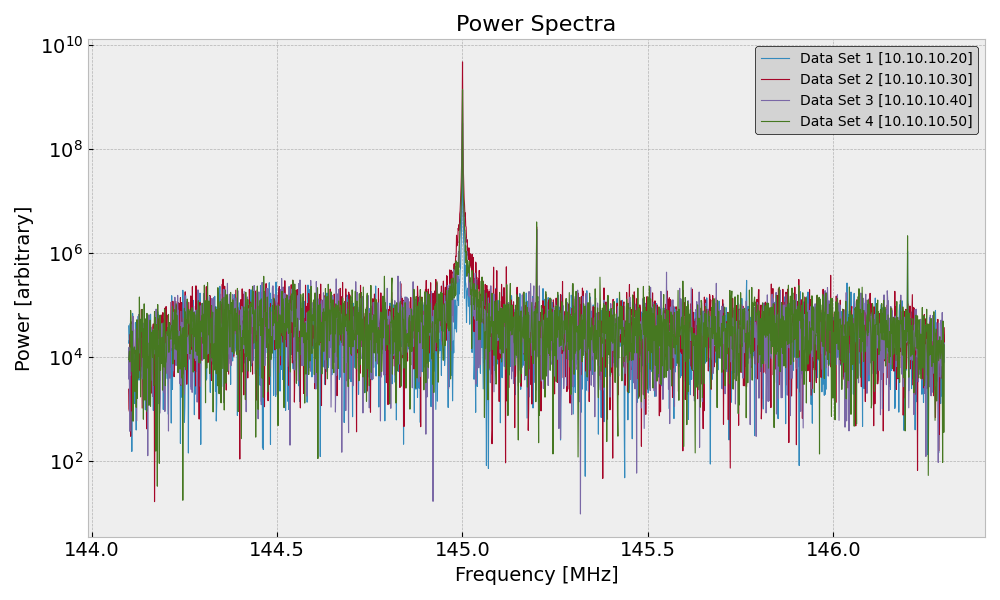

In [11]:
plt.figure(figsize=(10, 6))

# plots the power spectra
pwr_mean1 = shift(perform_power(fft(data_comp1)))
pwr_mean2 = shift(perform_power(fft(data_comp2)))
pwr_mean3 = shift(perform_power(fft(data_comp3)))
pwr_mean4 = shift(perform_power(fft(data_comp4)))

plt.semilogy(freqs, pwr_mean1[0], linewidth=0.8, label='Data Set 1 [10.10.10.20]')
plt.semilogy(freqs, pwr_mean2[0], linewidth=0.8, label='Data Set 2 [10.10.10.30]')
plt.semilogy(freqs, pwr_mean3[0], linewidth=0.8, label='Data Set 3 [10.10.10.40]')
plt.semilogy(freqs, pwr_mean4[0], linewidth=0.8, label='Data Set 4 [10.10.10.50]')

plt.title('Power Spectra', fontsize=16)
plt.xlabel('Frequency [MHz]', fontsize=14)
plt.ylabel('Power [arbitrary]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# limits decimal places on x-axis to one
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.tight_layout()

# adds a snazzy custom legend
plt.legend(loc='best', framealpha=1, frameon=True, facecolor='lightgray', edgecolor='k')

# shows the plot
plt.show()

In [12]:
# plt.figure(figsize=(8,12))

# # plots a nice waterfall plot
# plt.imshow(pwr_mean4.T, cmap='plasma', aspect='auto', extent=[np.min(time), np.max(time), int(np.min(freqs)), int(np.max(freqs))])
# plt.xlabel('Time [ms]')
# plt.ylabel('Frequency [MHz]')
# plt.colorbar(label='Power [arbitrary]')
# plt.grid(False)

# plt.show()


In [ ]:
#corr1 = signal.correlate(data_comp1, data_comp2, mode='full', method='fft')
#corr2 = signal.correlate(data_comp2, data_comp3, mode='full', method='fft')
#corr3 = signal.correlate(data_comp3, data_comp4, mode='full', method='fft')
corr4 = signal.correlate(data_comp1, data_comp4, mode='full', method='fft')

#corr1 = pwr_mean1[:13312] * pwr_mean2[:13312]
#corr2 = pwr_mean2[:13312] * pwr_mean3[:13312]
#corr3 = pwr_mean3[:13312] * pwr_mean4[:13312]
#corr4 = pwr_mean1[:13312] * pwr_mean4[:13312]



     Data Set 1 shape: (2048, 13440)
     Data Set 2 shape: (2048, 13312)
Correlated Data shape: (4095, 26751)


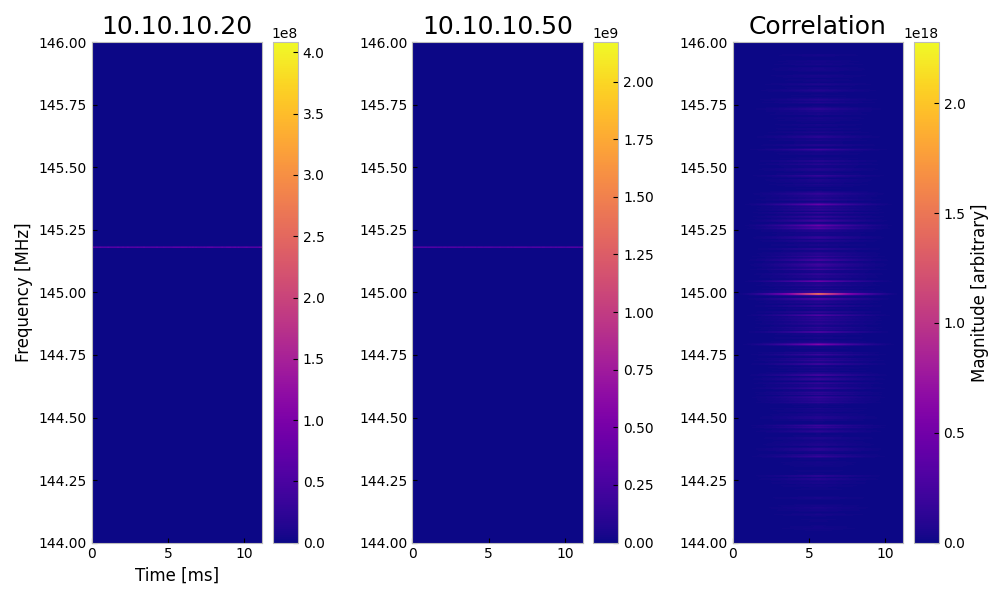

In [ ]:
print("     Data Set 1 shape:", np.shape(pwr_mean1.T))
print("     Data Set 2 shape:", np.shape(pwr_mean4.T))
print("Correlated Data shape:", np.shape(corr4.T))

plt.figure(figsize=(10, 6))

# subplot for pwr_mean2
plt.subplot(1, 3, 1)
plt.imshow(pwr_mean1.T, cmap='plasma', aspect='auto', extent=[np.min(time), np.max(time), int(np.min(freqs)), int(np.max(freqs))])
plt.colorbar(label='')
plt.title(f'{ip_addresses[0]}', fontsize=18)
plt.xlabel('Time [ms]')
plt.ylabel('Frequency [MHz]')
plt.grid(False)

# subplot for pwr_mean3
plt.subplot(1, 3, 2)
plt.imshow(pwr_mean4.T, cmap='plasma', aspect='auto', extent=[np.min(time), np.max(time), int(np.min(freqs)), int(np.max(freqs))])
plt.colorbar()
plt.title(f'{ip_addresses[3]}', fontsize=18)
#plt.gca().set_yticklabels([])  # hides the y-axis tick marks
plt.ylabel(' ')  # hides the y-axis label
plt.grid(False)

# subplot for corr1 np.abs and np.angle
plt.subplot(1, 3, 3)
plt.imshow(np.abs(corr4)**2, cmap='plasma', aspect='auto', extent=[np.min(time), np.max(time), int(np.min(freqs)), int(np.max(freqs))])
plt.colorbar(label='Magnitude [arbitrary]')
plt.title('Correlation', fontsize=18)
#plt.yticks([])  # hides the y-axis tick marks
#plt.gca().set_yticklabels([])  # hides the y-axis label
#plt.xlabel('Time [ms]')
plt.grid(False)

# subplot for corr1 np.abs and np.angle
# plt.subplot(1, 4, 4)
# plt.imshow(np.angle(corr2), cmap='plasma', aspect='auto', extent=[np.min(time), np.max(time), int(np.min(freqs)), int(np.max(freqs))])
# plt.colorbar(label='')
# plt.title('Phase of Correlation', fontsize=18)
# #plt.yticks([])  # hides the y-axis tick marks
# plt.ylabel('')  # hides the y-axis label
# plt.xlabel('Time [ms]')
# plt.grid(False)

plt.tight_layout()
plt.show()


     Data Set 1 shape: (2048, 13312)
     Data Set 2 shape: (2048, 13440)
Correlated Data shape: (4095, 26751)


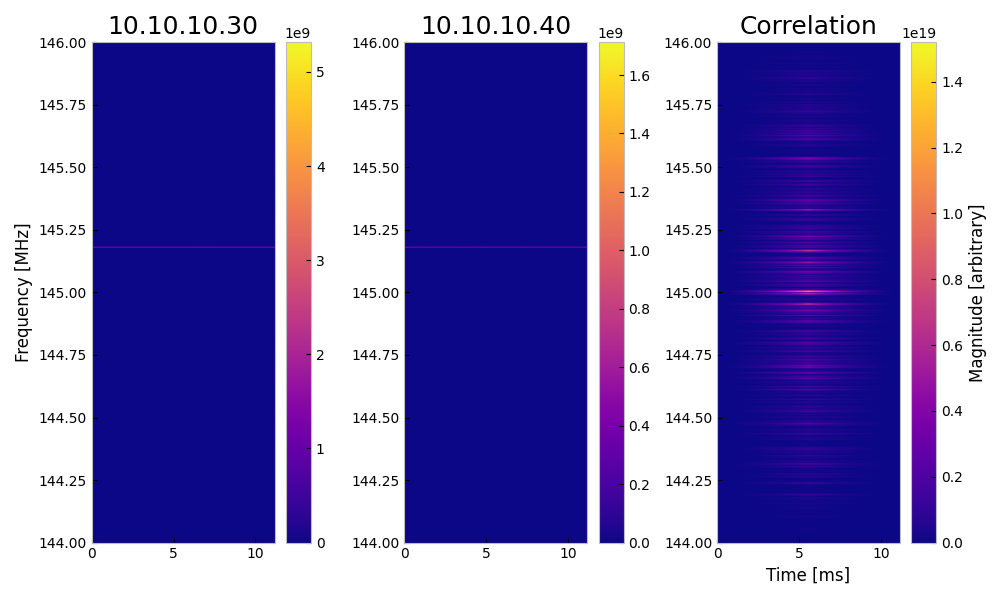

In [ ]:
# print("     Data Set 1 shape:", np.shape(pwr_mean2.T))
# print("     Data Set 2 shape:", np.shape(pwr_mean3.T))
# print("Correlated Data shape:", np.shape(corr2.T))

# plt.figure(figsize=(10, 6))

# # subplot for pwr_mean2
# plt.subplot(1, 3, 1)
# plt.imshow(pwr_mean2.T, cmap='plasma', aspect='auto', extent=[np.min(time), np.max(time), int(np.min(freqs)), int(np.max(freqs))])
# plt.colorbar(label='')
# plt.title(f'{ip_addresses[1]}', fontsize=18)
# plt.ylabel('Frequency [MHz]')
# plt.grid(False)

# # subplot for pwr_mean3
# plt.subplot(1, 3, 2)
# plt.imshow(pwr_mean3.T, cmap='plasma', aspect='auto', extent=[np.min(time), np.max(time), int(np.min(freqs)), int(np.max(freqs))])
# plt.colorbar(label='')
# plt.title(f'{ip_addresses[2]}', fontsize=18)
# #plt.yticks([])  # hides the y-axis tick marks
# plt.ylabel('')  # hides the y-axis label
# plt.grid(False)

# # subplot for corr1 np.abs and np.angle
# plt.subplot(1, 3, 3)
# plt.imshow(np.abs(corr2)**2, cmap='plasma', aspect='auto', extent=[np.min(time), np.max(time), int(np.min(freqs)), int(np.max(freqs))])
# plt.colorbar(label='Magnitude [arbitrary]')
# plt.title('Correlation', fontsize=18)
# #plt.yticks([])  # hides the y-axis tick marks
# plt.ylabel('')  # hides the y-axis label
# plt.xlabel('Time [ms]')
# plt.grid(False)

# # subplot for corr1 np.abs and np.angle
# # plt.subplot(1, 4, 4)
# # plt.imshow(np.angle(corr2), cmap='plasma', aspect='auto', extent=[np.min(time), np.max(time), int(np.min(freqs)), int(np.max(freqs))])
# # plt.colorbar(label='')
# # plt.title('Phase of Correlation', fontsize=18)
# # #plt.yticks([])  # hides the y-axis tick marks
# # plt.ylabel('')  # hides the y-axis label
# # plt.xlabel('Time [ms]')
# # plt.grid(False)

# plt.tight_layout()
# plt.show()

Data shapes: [13440, 13312, 13440, 13312]


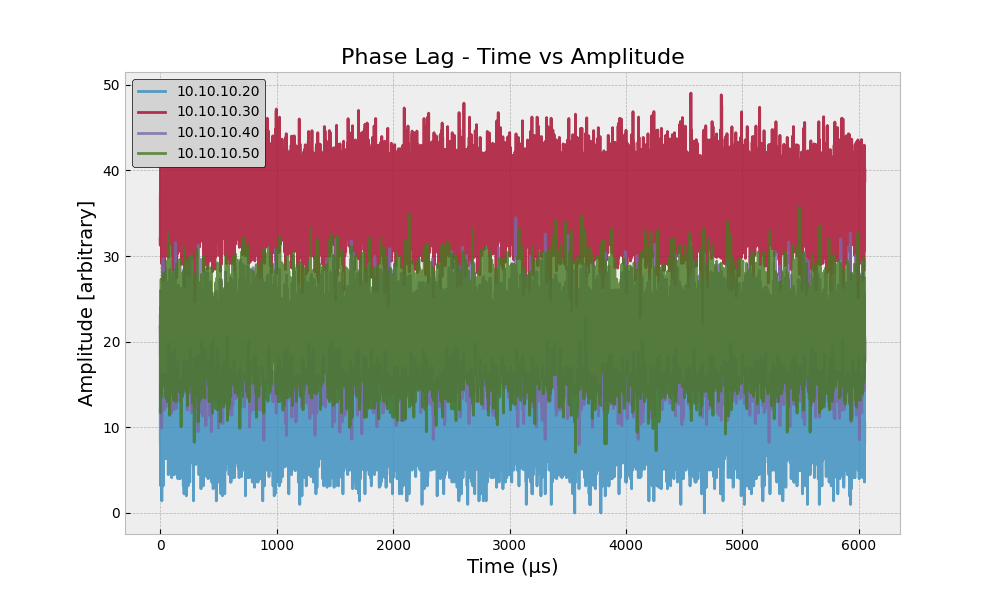

In [24]:
# function that computes amplitude of given signal
def compute_amplitude(signal):
    return np.abs(signal)

# function that shifts the signal over
def shift(signal):
    return fftshift(signal)

# creates a time array based on the length of the concatenated data
time_length = min(data1.shape[0], data2.shape[0], data3.shape[0]) / sampling_rate
time = np.arange(0, time_length, 1/sampling_rate)

# function that plots phase lag with matching dimensions
def plot_phase_lag(time, signals, labels):
    plt.figure(figsize=(10, 6))

    for signal, label in zip(signals, labels):
        amplitude = compute_amplitude(signal)
        # trims the amplitude to match the time array length
        amplitude = amplitude[:len(time), 0]  

        plt.plot(time, amplitude, label=label, alpha=0.8)

    plt.xlabel('Time (µs)', fontsize=14)
    plt.ylabel('Amplitude [arbitrary]', fontsize=14)
    plt.legend(loc='upper left', framealpha=1, frameon=True, facecolor='lightgray', edgecolor='k')
    plt.title('Phase Lag - Time vs Amplitude', fontsize=16)
    plt.show()

# checks the dimensions and plots
if data1.shape[0] >= len(time) and data2.shape[0] >= len(time) and data3.shape[0] >= len(time):
    signals = [data_comp1, data_comp2, data_comp3, data_comp4]
    labels = [f"{ip}" for ip in ip_addresses]
    print(f'Data shapes: {[data1.shape[0], data2.shape[0], data3.shape[0], data4.shape[0]]}')
    plot_phase_lag(time, signals, labels)
else:
    print('Data and time dimensions do not match!')


## Leave all hope, ye who go beyond here!
### (Very rough testing of random stuff)

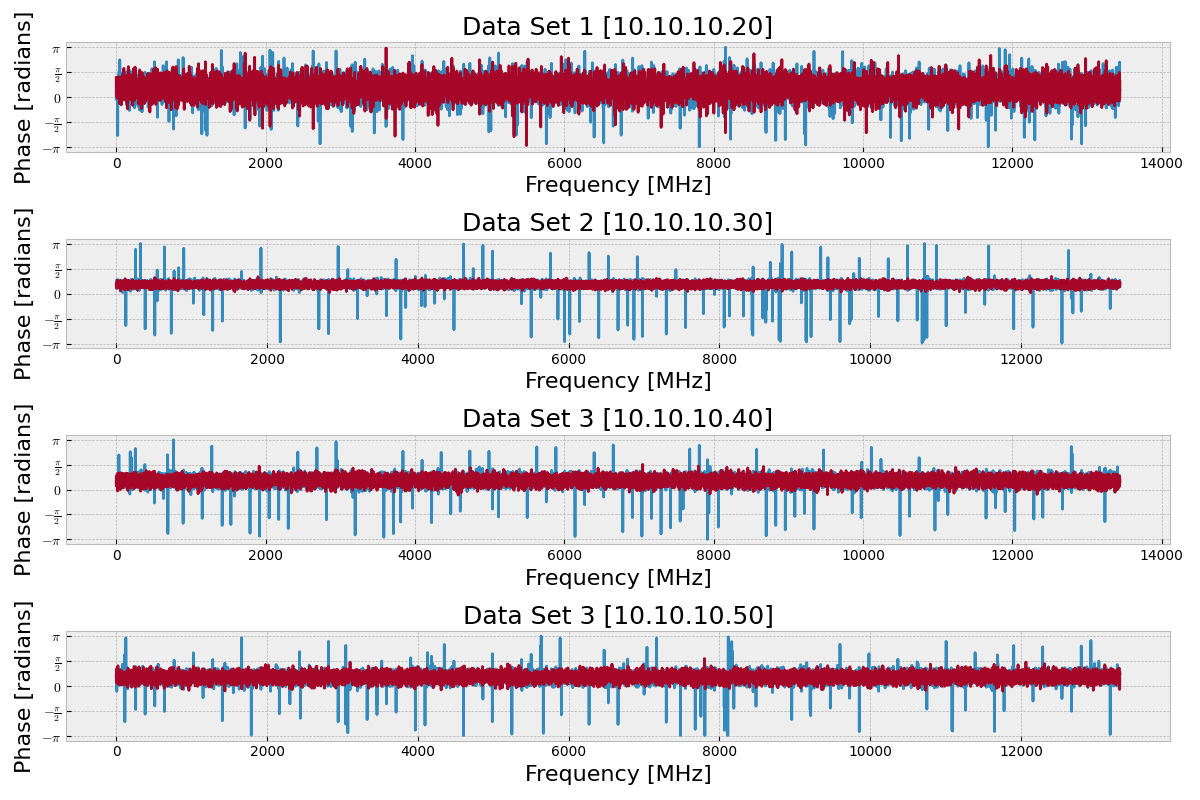

In [25]:
# creates a figure with 3 subplots
plt.figure(figsize=(12, 8))

# subplot for data_comp1
plt.subplot(4, 1, 1)
plt.plot(np.angle(data_comp1[:-1, -1] * data_comp1[1:, 0].conj()), label='Real')
plt.plot(np.angle(data_comp1[:, -2] * data_comp1[:, -1].conj()), label='Imaginary')
plt.xlabel('Frequency [MHz]', fontsize=16)
plt.ylabel('Phase [radians]', fontsize=16)
plt.title('Data Set 1 [10.10.10.20]', fontsize=18)
plt.yticks(np.linspace(-np.pi, np.pi, 5), [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
plt.gca().ticklabel_format(axis='x', style='plain')

# subplot for data_comp2
plt.subplot(4, 1, 2)
plt.plot(np.angle(data_comp2[:-1, -1] * data_comp2[1:, 0].conj()), label='Real')
plt.plot(np.angle(data_comp2[:, -2] * data_comp2[:, -1].conj()), label='Imaginary')
plt.xlabel('Frequency [MHz]', fontsize=16)
plt.ylabel('Phase [radians]', fontsize=16)
plt.title('Data Set 2 [10.10.10.30]', fontsize=18)
plt.yticks(np.linspace(-np.pi, np.pi, 5), [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
plt.gca().ticklabel_format(axis='x', style='plain')

# subplot for data_comp3
plt.subplot(4, 1, 3)
plt.plot(np.angle(data_comp3[:-1, -1] * data_comp3[1:, 0].conj()), label='Real')
plt.plot(np.angle(data_comp3[:, -2] * data_comp3[:, -1].conj()), label='Imaginary')
plt.xlabel('Frequency [MHz]', fontsize=16)
plt.ylabel('Phase [radians]', fontsize=16)
plt.title('Data Set 3 [10.10.10.40]', fontsize=18)
plt.yticks(np.linspace(-np.pi, np.pi, 5), [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
plt.gca().ticklabel_format(axis='x', style='plain')

# subplot for data_comp4
plt.subplot(4, 1, 4)
plt.plot(np.angle(data_comp4[:-1, -1] * data_comp4[1:, 0].conj()), label='Real')
plt.plot(np.angle(data_comp4[:, -2] * data_comp4[:, -1].conj()), label='Imaginary')
plt.xlabel('Frequency [MHz]', fontsize=16)
plt.ylabel('Phase [radians]', fontsize=16)
plt.title('Data Set 3 [10.10.10.50]', fontsize=18)
plt.yticks(np.linspace(-np.pi, np.pi, 5), [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
plt.gca().ticklabel_format(axis='x', style='plain')

plt.tight_layout()

plt.show()


In [18]:
# # Number of signals
# num_signals = len(data_comps)

# # Initialize the correlation matrix
# correlation_matrix = np.zeros((num_signals, num_signals, 2 * time_num - 1))

# # Compute the correlation matrix
# for i in range(num_signals):
#     for j in range(i, num_signals):
#         signal1 = np.unwrap(np.angle(data_comps[i].ravel()[offset:offset+time_num] * phazor))
#         signal2 = np.unwrap(np.angle(data_comps[j].ravel()[offset:offset+time_num] * phazor))
        
#         # Compute cross-correlation
#         corr = correlate(signal1, signal2, mode='full')
#         correlation_matrix[i, j, :] = corr
#         if i != j:
#             correlation_matrix[j, i, :] = corr  # Symmetric matrix

# # Average correlations across all pairs for simplicity
# avg_correlation = np.mean(correlation_matrix, axis=0)

# # Plot the average correlation matrix
# plt.figure(figsize=(16, 8))
# plt.imshow(avg_correlation, aspect='auto', cmap='plasma', origin='lower')
# plt.colorbar(label='Average Correlation')
# plt.xlabel('Lag [samples]')
# plt.ylabel('Signal Pair')
# plt.title('Average Cross-Correlation Matrix')

# # Set tick labels for the x-axis
# plt.xticks(ticks=np.linspace(0, 2*time_num-1, num=5), labels=np.linspace(-time_num+1, time_num-1, num=5).astype(int)) # chatGPT added this, not sure if correct

# # Set tick labels for the y-axis
# yticks = np.arange(num_signals)
# yticklabels = [f'{labels[i]} vs {labels[j]}' for i in range(num_signals) for j in range(i, num_signals)] # chatGPT added this label thing, not sure if correct
# plt.yticks(ticks=yticks, labels=yticklabels[:num_signals])  # Adjust labels to match y-ticks
# plt.grid(False)

# plt.show()


In [19]:
# # creates a figure with 3 subplots for magnitude
# plt.figure(figsize=(12, 8))

# # subplot for data_comp1
# plt.subplot(1, 3, 1)
# plt.imshow(np.abs(data_comp1[:, :].real), cmap='plasma', interpolation='nearest', aspect='auto')
# plt.colorbar(label='Magnitude')
# plt.title('Data Set 1', fontsize=18)
# plt.grid(False)

# # subplot for data_comp2
# plt.subplot(1, 3, 2)
# plt.imshow(np.abs(data_comp2[:, :].real), cmap='plasma', interpolation='nearest', aspect='auto')
# plt.colorbar(label='Magnitude')
# plt.title('Data Set 2', fontsize=18)
# plt.grid(False)

# # subplot for data_comp4
# plt.subplot(1, 3, 3)
# plt.imshow(np.abs(data_comp4[:, :].real), cmap='plasma', interpolation='nearest', aspect='auto')
# plt.colorbar(label='Magnitude')
# plt.title('Data Set 3', fontsize=18)
# plt.grid(False)

# plt.tight_layout()
# plt.show()

In [20]:
# '''This is the transpose of the data plotted (switching x- and y-axes)'''

# # creates a figure with 3 subplots for magnitude
# plt.figure(figsize=(12, 8))

# # subplot for data_comp1
# plt.subplot(1, 3, 1)
# plt.imshow(np.abs(data_comp1[:, :].real).T, cmap='plasma', interpolation='nearest', aspect='auto')
# plt.colorbar(label='Magnitude')
# plt.title('Data Set 1', fontsize=18)
# plt.grid(False)

# # subplot for data_comp2
# plt.subplot(1, 3, 2)
# plt.imshow(np.abs(data_comp2[:, :].real).T, cmap='plasma', interpolation='nearest', aspect='auto')
# plt.colorbar(label='Magnitude')
# plt.title('Data Set 2', fontsize=18)
# plt.grid(False)

# # subplot for data_comp4
# plt.subplot(1, 3, 3)
# plt.imshow(np.abs(data_comp4[:, :].real).T, cmap='plasma', interpolation='nearest', aspect='auto')
# plt.colorbar(label='Magnitude')
# plt.title('Data Set 3', fontsize=18)
# plt.grid(False)

# plt.tight_layout()
# plt.show()

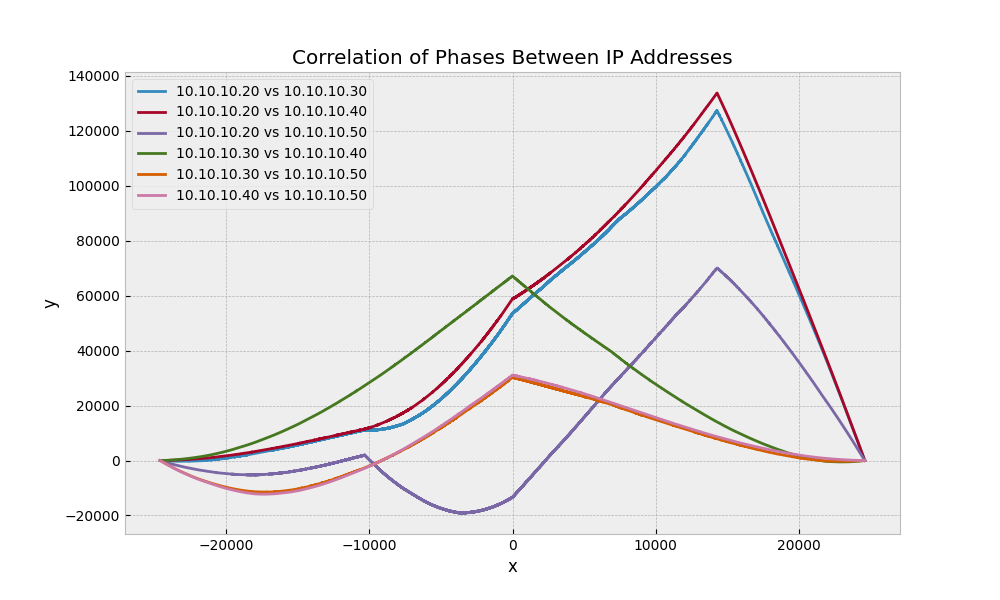

In [26]:
# not really sure what I did here

plt.figure(figsize=(10,6))
plt.title('Correlation of Phases Between IP Addresses')

# correlates each pair of signals
for i in range(len(data_comps)):
    for j in range(i+1, len(data_comps)):
        # grabs the signals to correlate
        signal1 = np.unwrap(np.angle(data_comps[i].ravel()[offset:offset+time_num] * phazor))
        signal2 = np.unwrap(np.angle(data_comps[j].ravel()[offset:offset+time_num] * phazor))
        
        # computes cross-correlation
        corr = correlate(signal1, signal2, mode='full')
        lags = np.arange(-len(signal1) + 1, len(signal1))
        
        # plots the cross-correlation
        plt.plot(lags, corr, label=f'{labels[i]} vs {labels[j]}')

plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

In [22]:
plt.close('all')